<a href="https://colab.research.google.com/github/ArtemkaDS/homework/blob/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%B5_%D0%94%D0%97_2_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="text-align: center;"><b>Большое домашнее задание 2. Участие в соревнованиях на Kaggle. Работа с нерепрезентативными данными.
</b></h2>

ДЗ в колабе: https://colab.research.google.com/drive/18Hi97eESCrXYht-7SIoj_19pwcZhl17Y?usp=sharing

В этом домашнем задании нам нужно применить в реальном соревновании накопленные знания по машинному обучению и анализу данных!

- Нужно будет провести предобработку [данных с Kaggle](https://www.kaggle.com/sid321axn/thoraric-surgery). Затем нужно будет предсказать колонку DGN (диагноз). Это задача классификации. 
- Описание датасета (что значит признаки): https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data 
- Не забудьте провести анализ данных перед тем, как применять ML-модели! Вам нужно сначала понять, с чем Вы имеете дело, поискать зависимости в данных, понять природу этих зависимостей, и только после этого уже подбирать алгоритмы. Данные с подвохом! Внимательно смотрите на распределения признаков в каждом из классов!
- В качестве основы можно использовать наработки с занятий. Необходимо попробовать сделать аугментацию данных, т.к. данных очень мало, для обучения содержательных моделей их не хватит.
- Попробуйте kNN, логистическую регрессию, SVM. Поэкспериментируйте с добавлением композитных признаков (например, полиномиальных), выбором ядра (для SVM). Подберите гиперпараметры по кросс-валидации (GridSearchCV или RandomSearchCV, второй вариант предпочтительнее).  
- Достичь идеального качества Вам не удастся, да и гнаться за этим не стоит. Гораздо важнее провести вдумчивый анализ и показать, что Вы разобрались в теме.

**Правила:**

- **Дедлайн один:** 29 января 23:59. Решения, отправленные позже, проверяться не будут, кроме случаев наличия уважительной причины.



Решения, размещенные на каких-либо интернет-ресурсах, не принимаются.
 При написании кода придерживайтесь `pep8` и используйте `type hints`.

**После жесткого дедлайна задания не принимаются. Так как дальше будет работа только над проектом**

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, KMeansSMOTE
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [101]:
data = pd.read_csv('ThoraricSurgery.csv', index_col='id')
booleanDictionary = {'T': 1, 'F': 0}
data = data.replace(booleanDictionary)
data['PRE6'] = data['PRE6'].astype('category').cat.codes
data['PRE14'] = data['PRE14'].astype('category').cat.codes
data.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
id,,,,,,,,,,,,,,,,,
1,DGN2,2.88,2.16,1,0,0,0,1,1,3,0,0,0,1,0,60,0
2,DGN3,3.40,1.88,0,0,0,0,0,0,1,0,0,0,1,0,51,0
3,DGN3,2.76,2.08,1,0,0,0,1,0,0,0,0,0,1,0,59,0
4,DGN3,3.68,3.04,0,0,0,0,0,0,0,0,0,0,0,0,54,0
5,DGN3,2.44,0.96,2,0,1,0,1,1,0,0,0,0,1,0,73,1


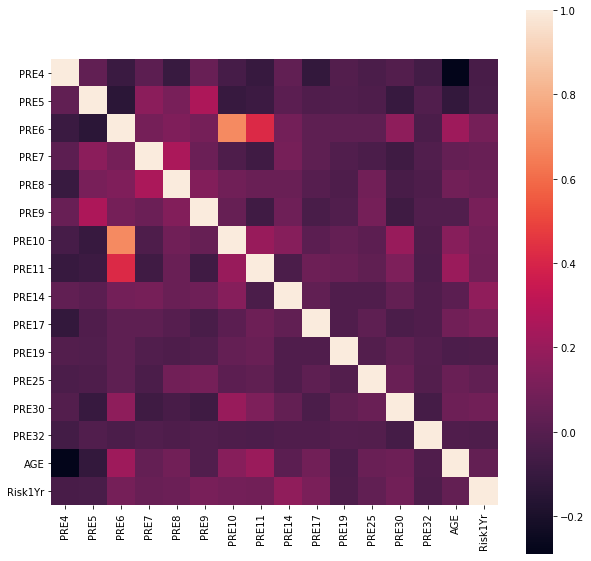

In [92]:
plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), square=True)

Существует не слишком большая корреляция между признаком PRE6 и признаками PRE10 и PRE11. Считаю, что все признаки можно оставить.

DGN
DGN1    AxesSubplot(0.125,0.125;0.775x0.755)
DGN2    AxesSubplot(0.125,0.125;0.775x0.755)
DGN3    AxesSubplot(0.125,0.125;0.775x0.755)
DGN4    AxesSubplot(0.125,0.125;0.775x0.755)
DGN5    AxesSubplot(0.125,0.125;0.775x0.755)
DGN6    AxesSubplot(0.125,0.125;0.775x0.755)
DGN8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PRE5, dtype: object

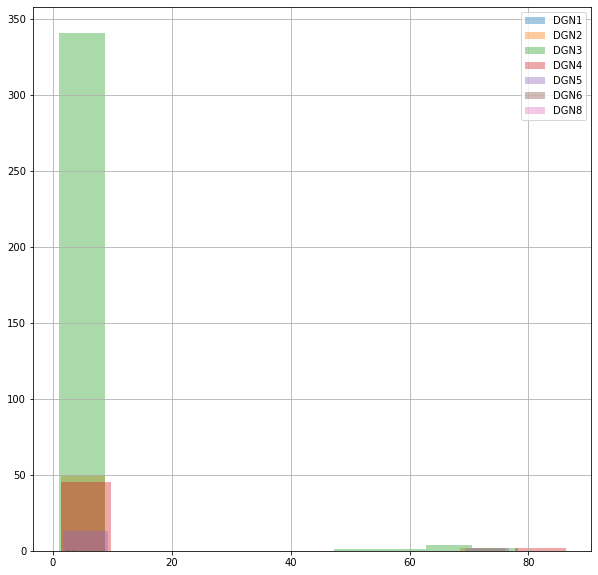

In [66]:
data.groupby('DGN').PRE5.hist(figsize=(10,10), alpha=0.4, legend=True)

PRE5: Volume that has been exhaled at the end of the first second of forced expiration - FEV1 (numeric) 

Это значение не может принимать такие кардинально отличающиеся значения. Также высокие значения представлены в нескольких классах. 
Считаю значения PRE5 > 25 выбросами

In [67]:
data = data.loc[data.PRE5 < 25]

DGN
DGN1    AxesSubplot(0.125,0.125;0.775x0.755)
DGN2    AxesSubplot(0.125,0.125;0.775x0.755)
DGN3    AxesSubplot(0.125,0.125;0.775x0.755)
DGN4    AxesSubplot(0.125,0.125;0.775x0.755)
DGN5    AxesSubplot(0.125,0.125;0.775x0.755)
DGN6    AxesSubplot(0.125,0.125;0.775x0.755)
DGN8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PRE5, dtype: object

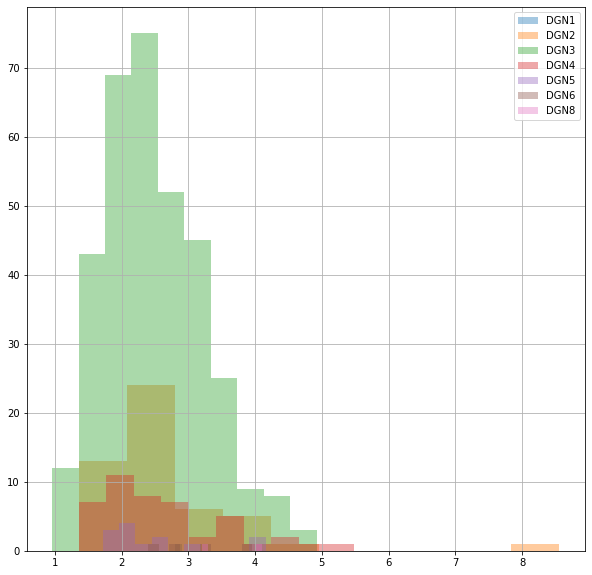

In [68]:
data.groupby('DGN').PRE5.hist(figsize=(10,10), alpha=0.4, legend=True)

DGN
DGN1    AxesSubplot(0.125,0.125;0.775x0.755)
DGN2    AxesSubplot(0.125,0.125;0.775x0.755)
DGN3    AxesSubplot(0.125,0.125;0.775x0.755)
DGN4    AxesSubplot(0.125,0.125;0.775x0.755)
DGN5    AxesSubplot(0.125,0.125;0.775x0.755)
DGN6    AxesSubplot(0.125,0.125;0.775x0.755)
DGN8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PRE19, dtype: object

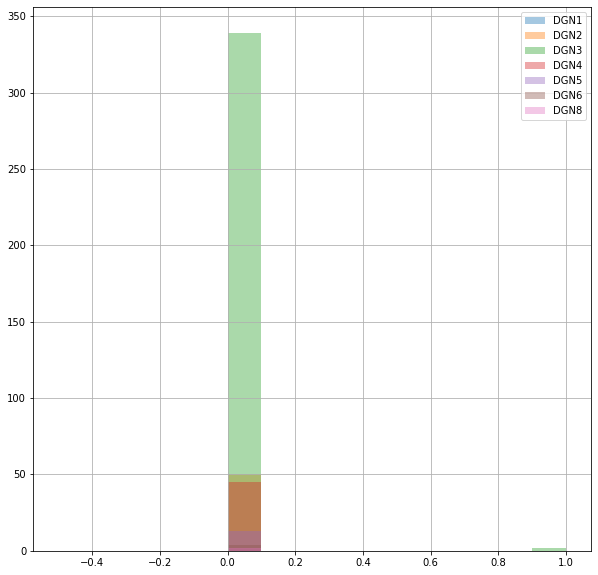

In [69]:
data.groupby('DGN').PRE19.hist(figsize=(10,10), alpha=0.4, legend=True)

DGN
DGN1    AxesSubplot(0.125,0.125;0.775x0.755)
DGN2    AxesSubplot(0.125,0.125;0.775x0.755)
DGN3    AxesSubplot(0.125,0.125;0.775x0.755)
DGN4    AxesSubplot(0.125,0.125;0.775x0.755)
DGN5    AxesSubplot(0.125,0.125;0.775x0.755)
DGN6    AxesSubplot(0.125,0.125;0.775x0.755)
DGN8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PRE32, dtype: object

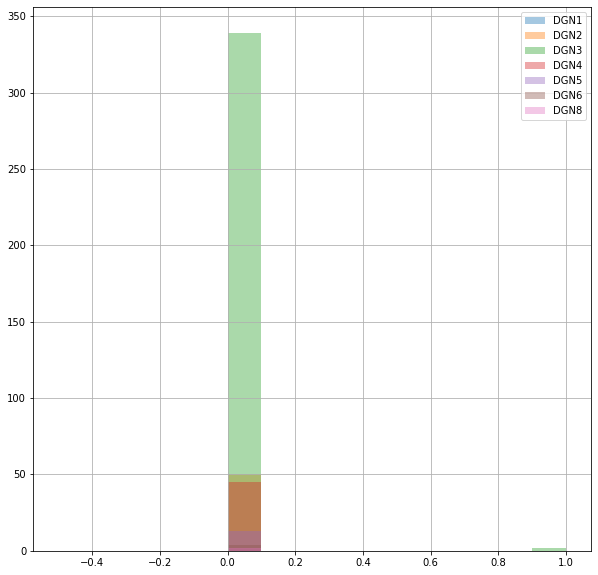

In [70]:
data.groupby('DGN').PRE32.hist(figsize=(10,10), alpha=0.4, legend=True)

Признак PRE19 можно исключить, так как существует только несколько объекта в классе DGN3, в которых PRE19 и PRE32 равны 1.

In [71]:
data = data.drop(columns=['PRE19', 'PRE32'])

DGN
DGN1    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN2    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN3    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN4    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN5    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN6    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
DGN8    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
dtype: object

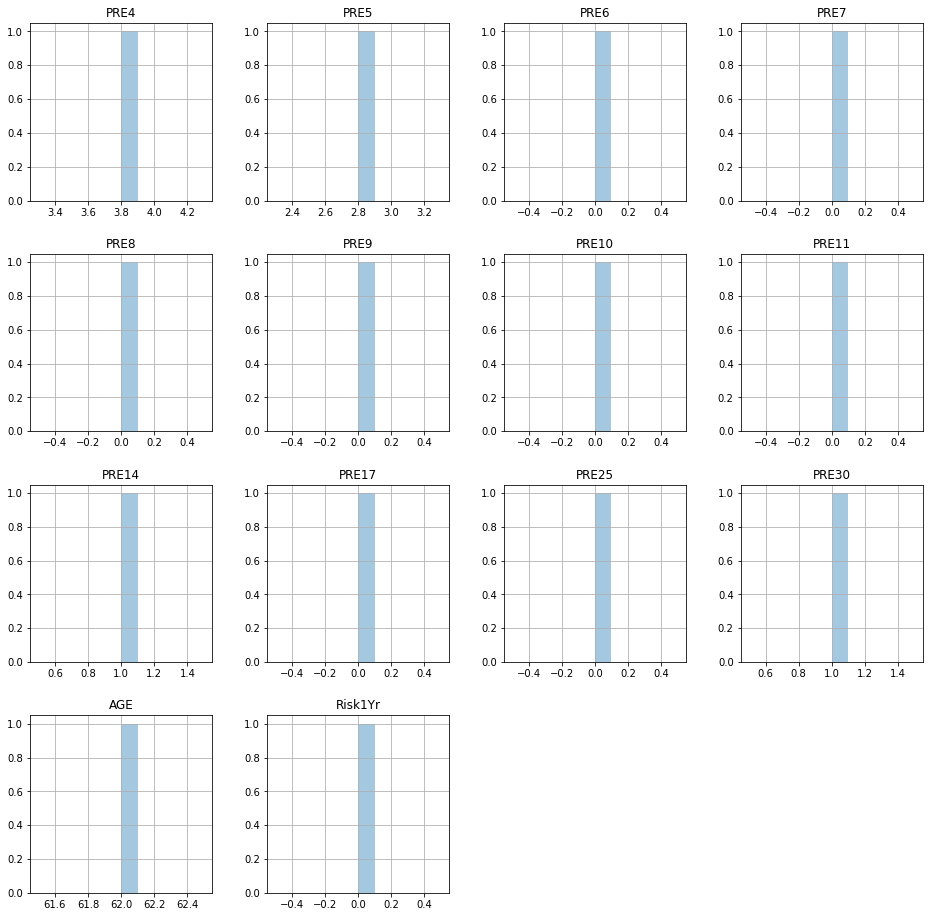

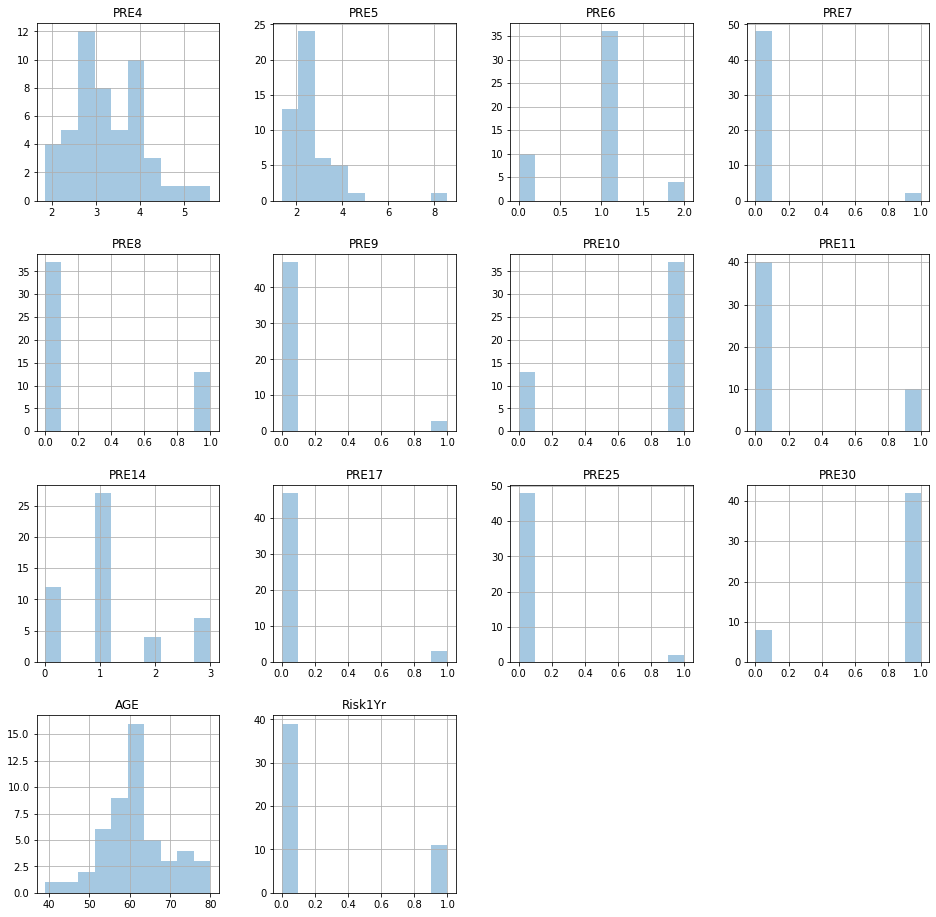

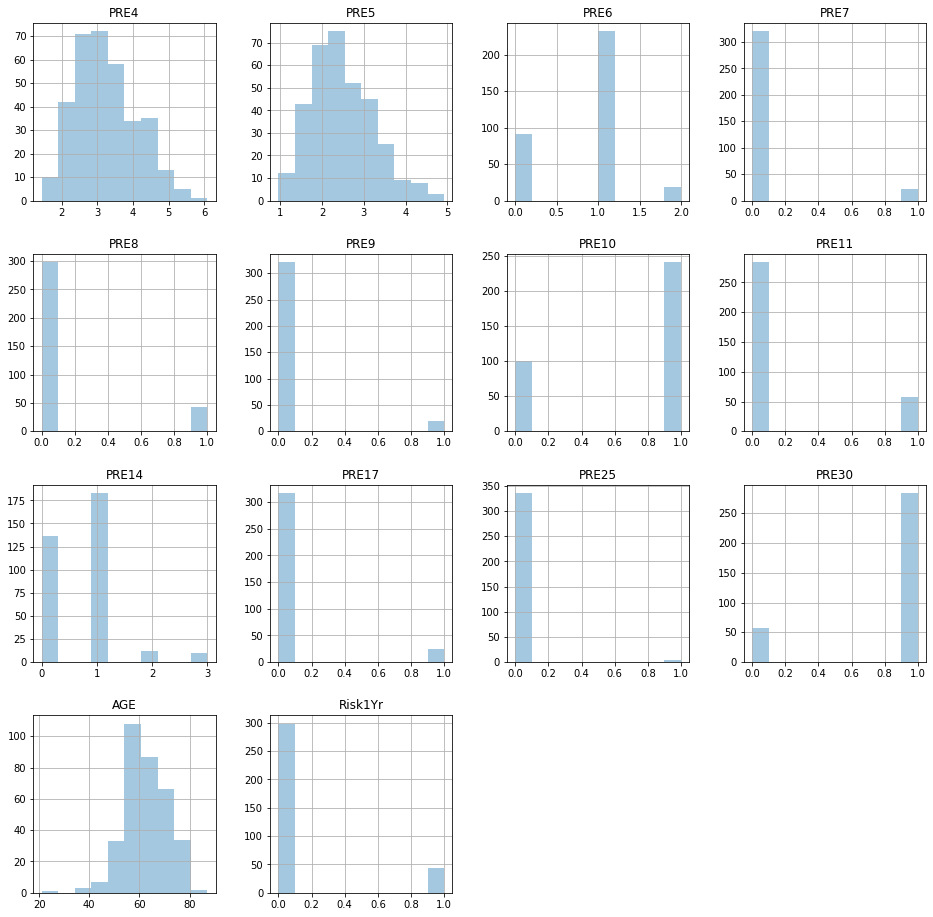

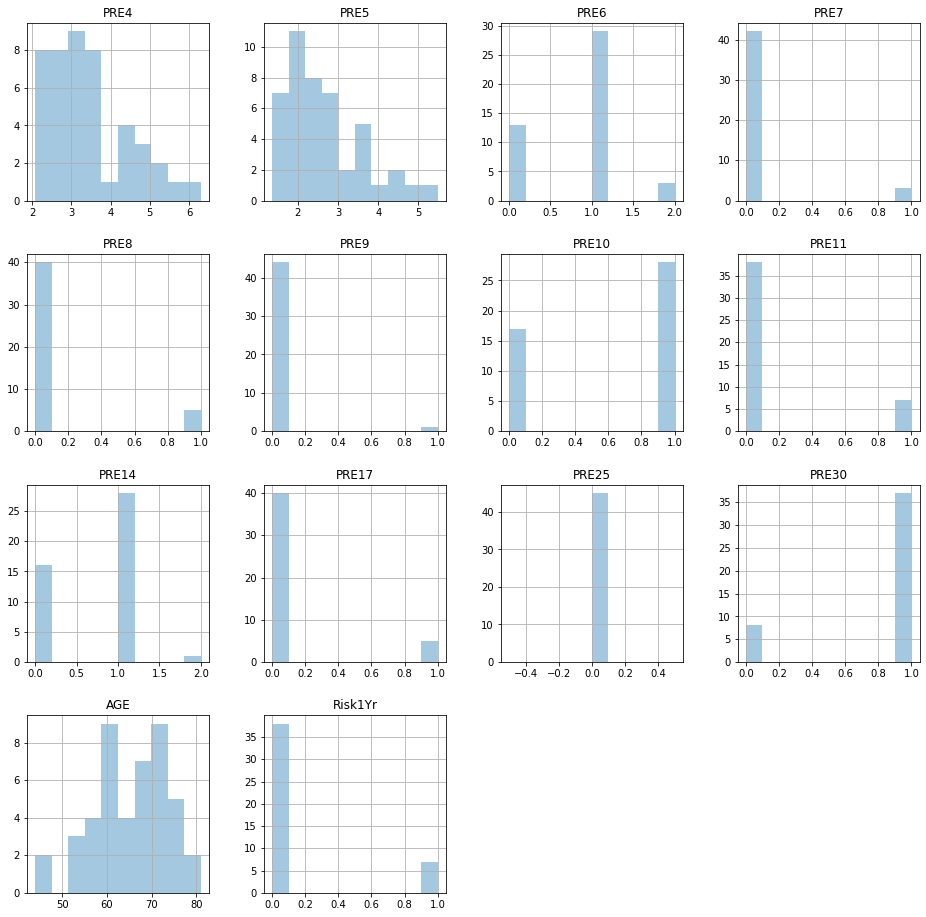

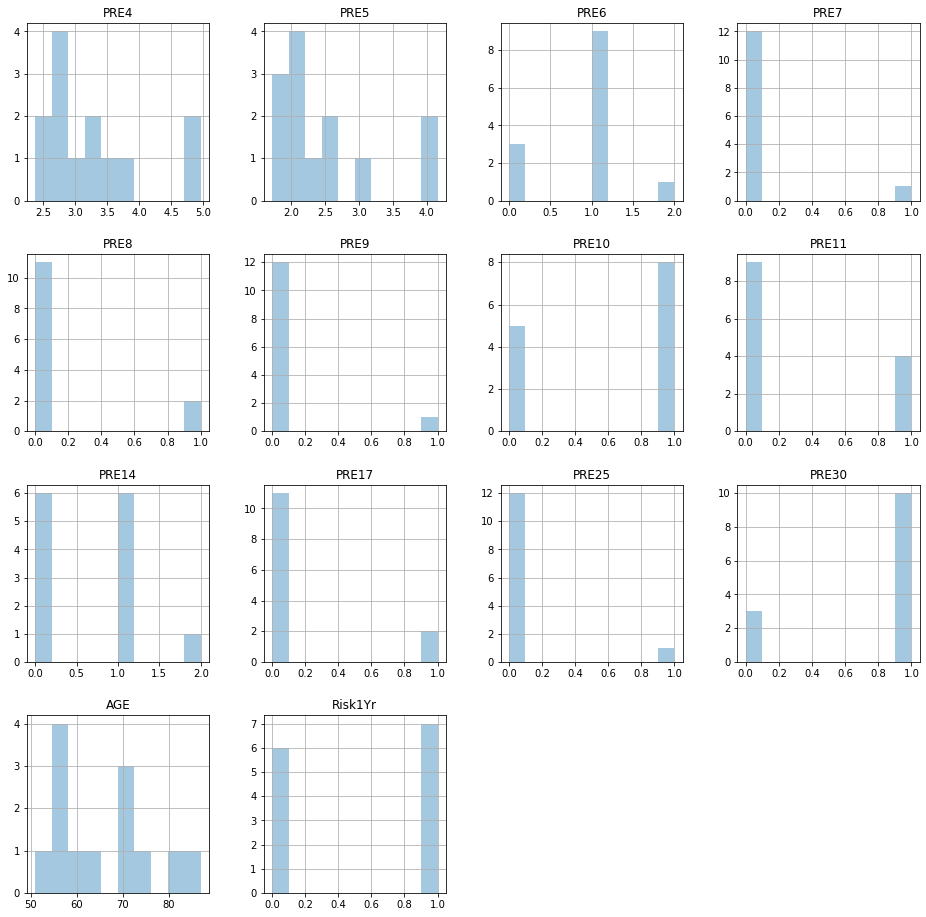

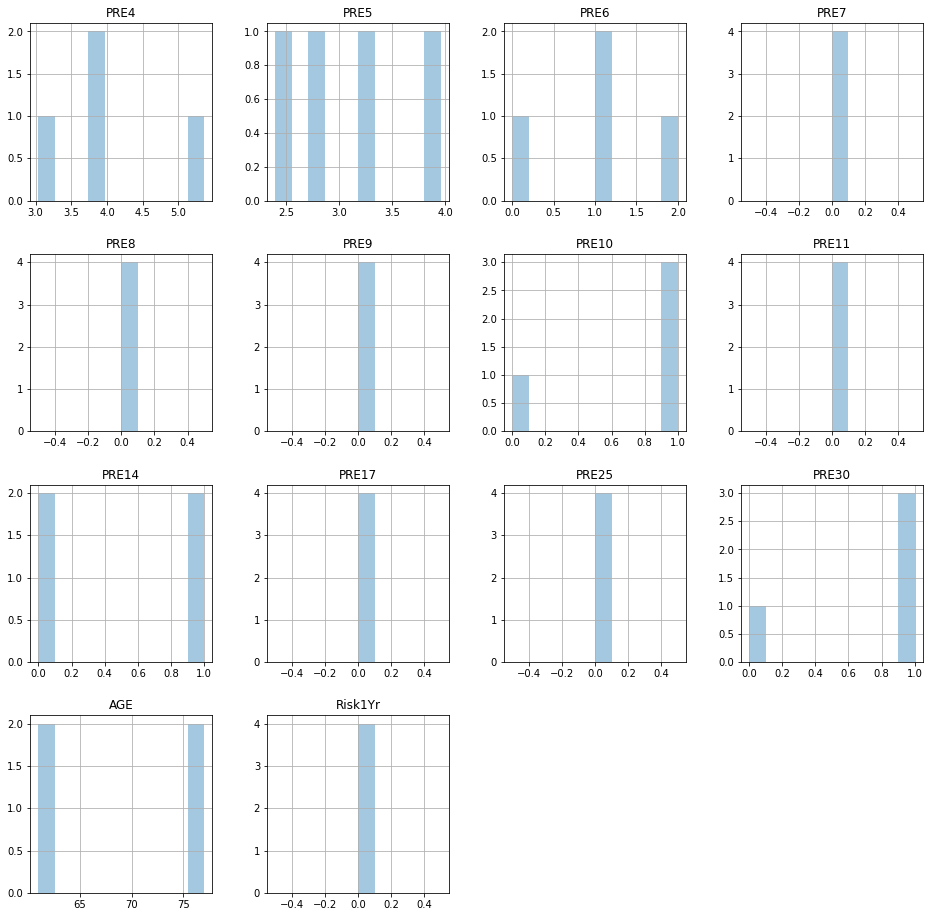

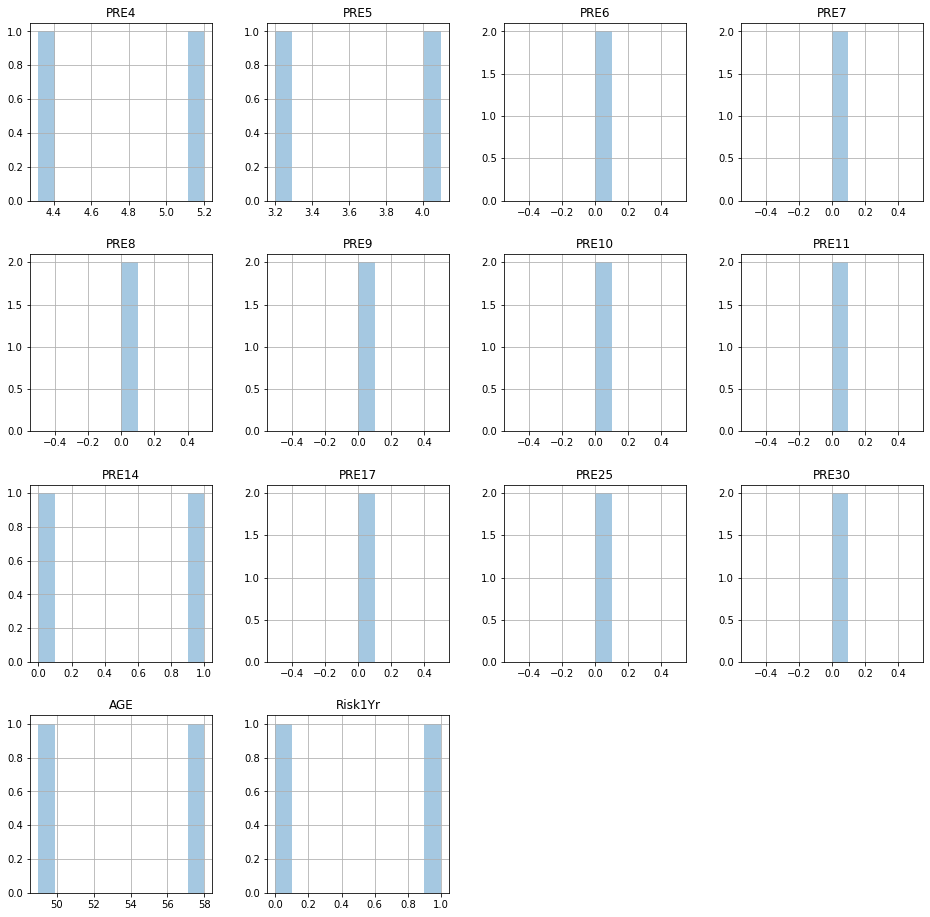

In [72]:
data.groupby('DGN').hist(figsize=(16,16), alpha=0.4)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 1 to 470
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DGN      456 non-null    object 
 1   PRE4     456 non-null    float64
 2   PRE5     456 non-null    float64
 3   PRE6     456 non-null    int8   
 4   PRE7     456 non-null    int64  
 5   PRE8     456 non-null    int64  
 6   PRE9     456 non-null    int64  
 7   PRE10    456 non-null    int64  
 8   PRE11    456 non-null    int64  
 9   PRE14    456 non-null    int8   
 10  PRE17    456 non-null    int64  
 11  PRE25    456 non-null    int64  
 12  PRE30    456 non-null    int64  
 13  AGE      456 non-null    int64  
 14  Risk1Yr  456 non-null    int64  
dtypes: float64(2), int64(10), int8(2), object(1)
memory usage: 50.8+ KB


In [74]:
data['DGN'].value_counts()

DGN3    341
DGN2     50
DGN4     45
DGN5     13
DGN6      4
DGN8      2
DGN1      1
Name: DGN, dtype: int64

В выборке существует всего один объект класса DGN1. В этом случае нет возможности разбить объекты класса DGN1 на тестовую и проверочную выборки. Удаляем этот объект из выборки, будем предсказывать только оставшееся классы.

In [75]:
data = data.loc[data['DGN'] != 'DGN1']

Так как некотрые классы имеют количество объектов меньшее, чем количество классов - используется RandomOverSampler для оверсемплинга.
Применение полиномальных признаков не дало улучшения моделей.

In [76]:
X = data.drop(columns=['DGN'])
y = data['DGN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

augm = RandomOverSampler(random_state=42)
X_train_augm, y_train_augm = augm.fit_resample(X_train, y_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 455 samples in 0.001s...
[t-SNE] Computed neighbors for 455 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 455 / 455
[t-SNE] Mean sigma: 1.443733
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.315735
[t-SNE] KL divergence after 300 iterations: 0.397948


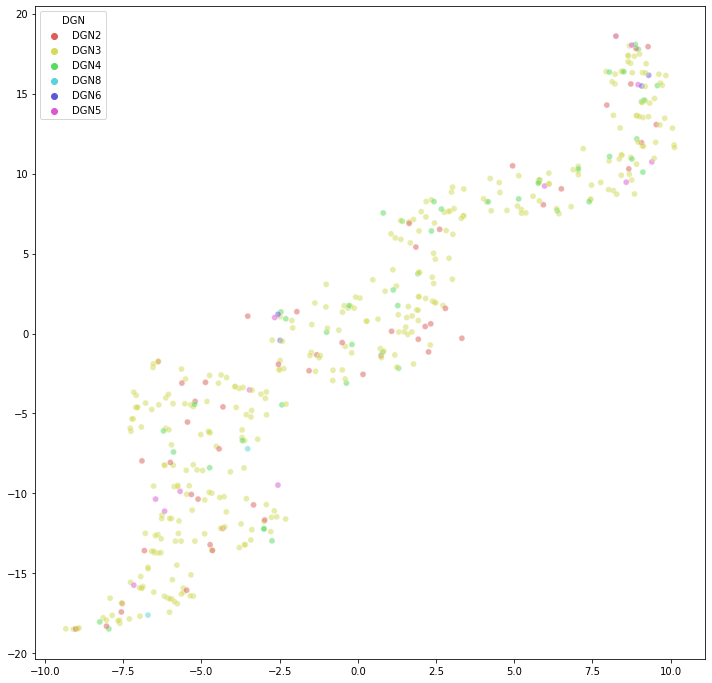

In [77]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
plt.figure(figsize=(12,12))
sns.scatterplot(
    tsne_results[:, 0],
    tsne_results[:, 1],
    hue=y,
    palette=sns.color_palette("hls", 6),
    legend="full",
    alpha=0.5
)

Поиск наилучшей модели с помощью RandomizedSearchCV. Метрика качества - f1_weighted. Кросс-валидация по 10 блокам.

In [78]:
knn = KNeighborsClassifier(n_jobs=-1)
distributions = dict(n_neighbors=[1, 2, 3, 5, 10],
                     weights=['uniform', 'distance'],
                    )
clf = RandomizedSearchCV(knn, distributions, scoring='f1_weighted', random_state=42, cv=10)
search = clf.fit(X_train_augm, y_train_augm)
print(classification_report(y_test, search.predict(X_test)))
search.best_params_

              precision    recall  f1-score   support

        DGN2       0.10      0.10      0.10        10
        DGN3       0.78      0.78      0.78        68
        DGN4       0.17      0.22      0.19         9
        DGN5       0.00      0.00      0.00         3
        DGN6       0.00      0.00      0.00         1

    accuracy                           0.62        91
   macro avg       0.21      0.22      0.21        91
weighted avg       0.61      0.62      0.61        91



{'n_neighbors': 1, 'weights': 'uniform'}

In [80]:
svm = SVC(max_iter=10000)
distributions = dict(C=np.linspace(1e+2, 1e+5, 1000),
                     kernel=['linear', 'poly', 'rbf', 'sigmoid'])
clf = RandomizedSearchCV(svm, distributions, scoring='f1_weighted', random_state=42, cv=10)
search = clf.fit(X_train_augm, y_train_augm)
print(classification_report(y_test, search.predict(X_test)))
search.best_params_

              precision    recall  f1-score   support

        DGN2       0.13      0.40      0.20        10
        DGN3       0.87      0.38      0.53        68
        DGN4       0.13      0.33      0.19         9
        DGN5       0.00      0.00      0.00         3
        DGN6       0.00      0.00      0.00         1
        DGN8       0.00      0.00      0.00         0

    accuracy                           0.36        91
   macro avg       0.19      0.19      0.15        91
weighted avg       0.68      0.36      0.44        91



{'C': 28300.0, 'kernel': 'rbf'}

In [81]:
logistic = LogisticRegression()
distributions = dict(C=np.linspace(1e-5, 1e+5, 1000),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, scoring='f1_weighted', random_state=42, cv=10)
search = clf.fit(X_train_augm, y_train_augm)
print(classification_report(y_test, search.predict(X_test)))
search.best_params_

              precision    recall  f1-score   support

        DGN2       0.17      0.40      0.24        10
        DGN3       0.81      0.31      0.45        68
        DGN4       0.08      0.11      0.09         9
        DGN5       0.08      0.33      0.13         3
        DGN6       0.00      0.00      0.00         1
        DGN8       0.00      0.00      0.00         0

    accuracy                           0.30        91
   macro avg       0.19      0.19      0.15        91
weighted avg       0.63      0.30      0.37        91



{'C': 43043.043048738735, 'penalty': 'l2'}

Выборка сложно разделима.
В ходе исследования получилось найти часть выбросов и несущественных признаков и применить Oversampling.
При этом удалось обучить модель, превосходящую статично выдающую DGN3 класс.

Наилучшей моделью оказалась модель 1-го ближайшего соседа. Для меры качества - точность и f-мера.
Объясняется это тем, что выборка плохо разделима и объекты класса DGN3 представлены во всех областях, поэтому эффективнее выбирать класс ближайшего соседа. 

С помощью полиномальных признаков различной степени лучшего результата достичь не получилось.